In [1]:
""" 
11 MARCH 2024 
Theo Gauvrit
Testing if there is higher trial by trial variability in recruitment of neurons in KO 
"""

import numpy as np
import pandas as pd
import percephone.core.recording as pc
import os
import percephone.plts.behavior as pbh
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
import percephone.analysis.mlr_models as mlr_m
from multiprocessing import Pool, cpu_count, pool
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline

In [2]:
user = "Célien"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    
roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    rec.peak_delay_amp()
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
    pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.


Initiating all recordings with multiprocessing

Function that will generate the cosine similarity matrix

In [3]:
def cosine_matrix(ax, rec, amplitude, resp_mat):
    print("Cosine similarity computation")

    sim_mat = cosine_similarity(resp_mat)
    ax.imshow(sim_mat, cmap="seismic", vmin=-1, vmax=+1, interpolation="none")
    ax.set_xlabel("Trial i")
    ax.set_ylabel("Trial j")
    ax.set_title(str(rec.filename) + " " + rec.genotype + " " + str(amplitude))

# Cosine similarity based on responsivity

---

## Cosine similarity matrices for every trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


Text(0.5, 0.98, 'Cosine similarity for all trials')

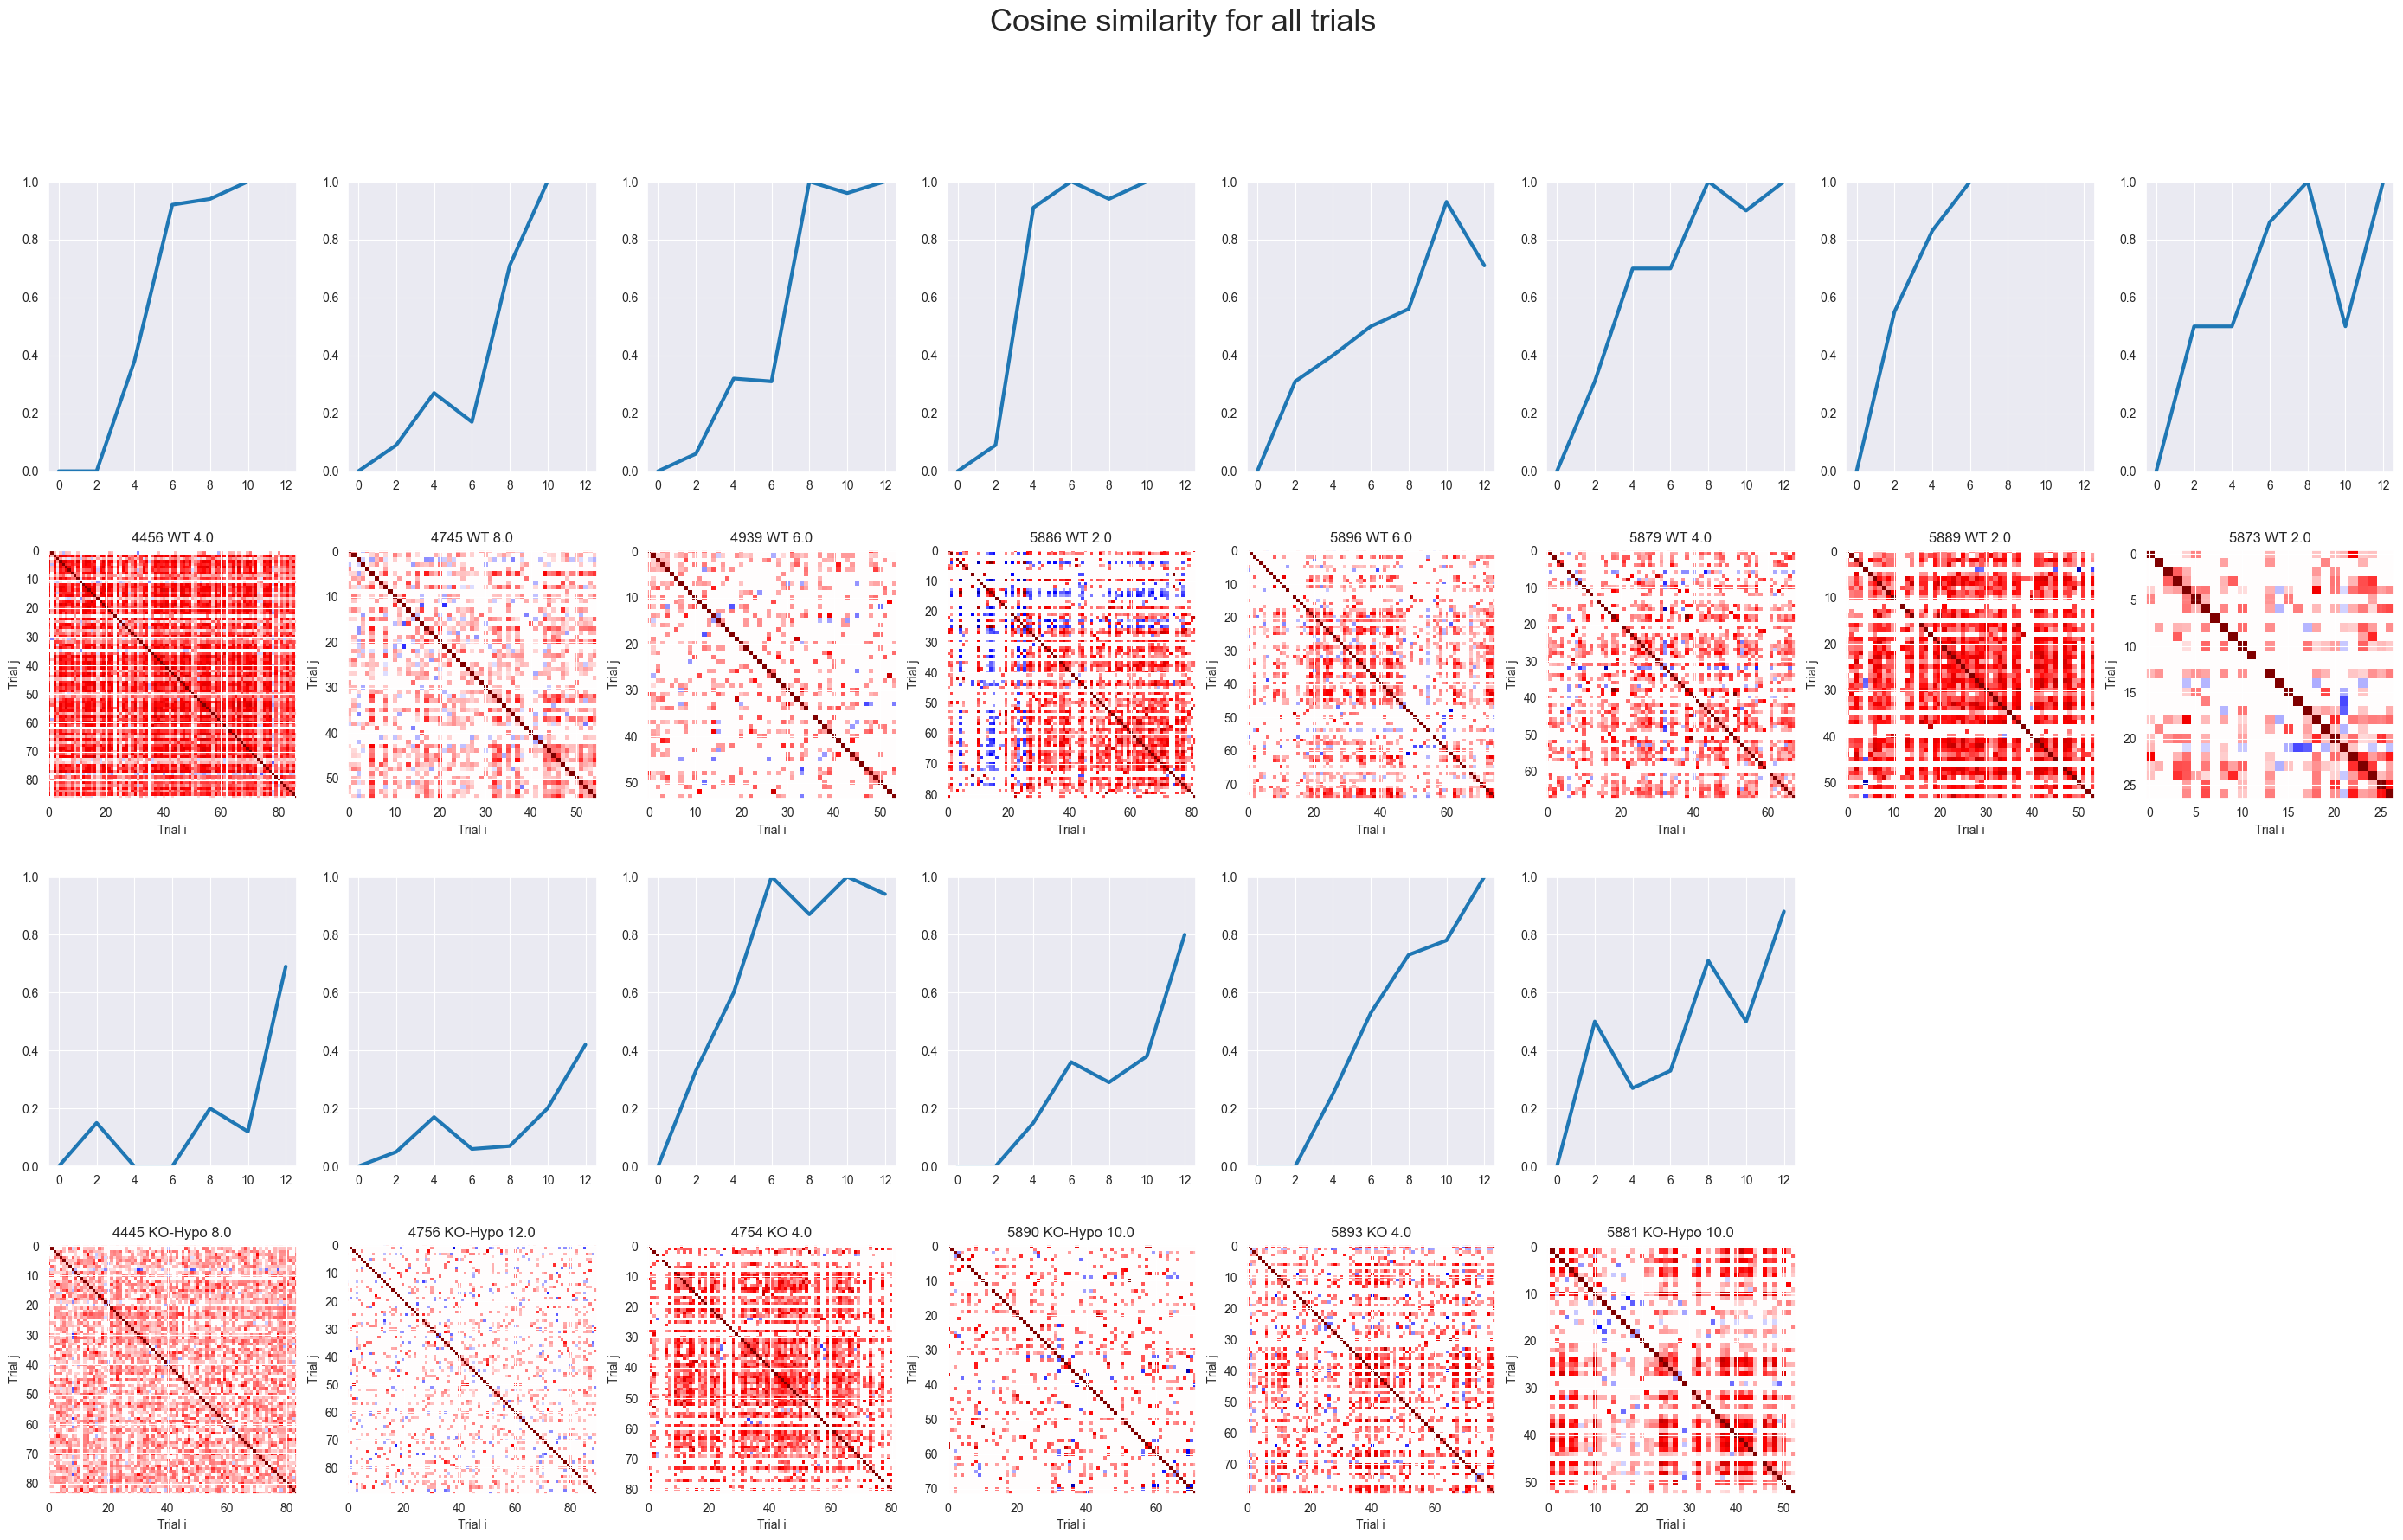

In [4]:
y, i = 0, 0
amps = [2, 6,6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(35, 20))

for rec, amp in zip(recs.values(), amps):
        # rec.responsivity()
        resp_m=np.transpose(rec.matrices["EXC"]["Responsivity"])
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            cosine_matrix(ax[1, i], rec, rec.threshold,resp_m)
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            cosine_matrix(ax[3, y], rec, rec.threshold,resp_m)
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Cosine similarity for all trials', fontsize=26)

## Cosine similarity matrices for every detected trials


Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


Text(0.5, 0.98, 'Cosine similarity for detected trials')

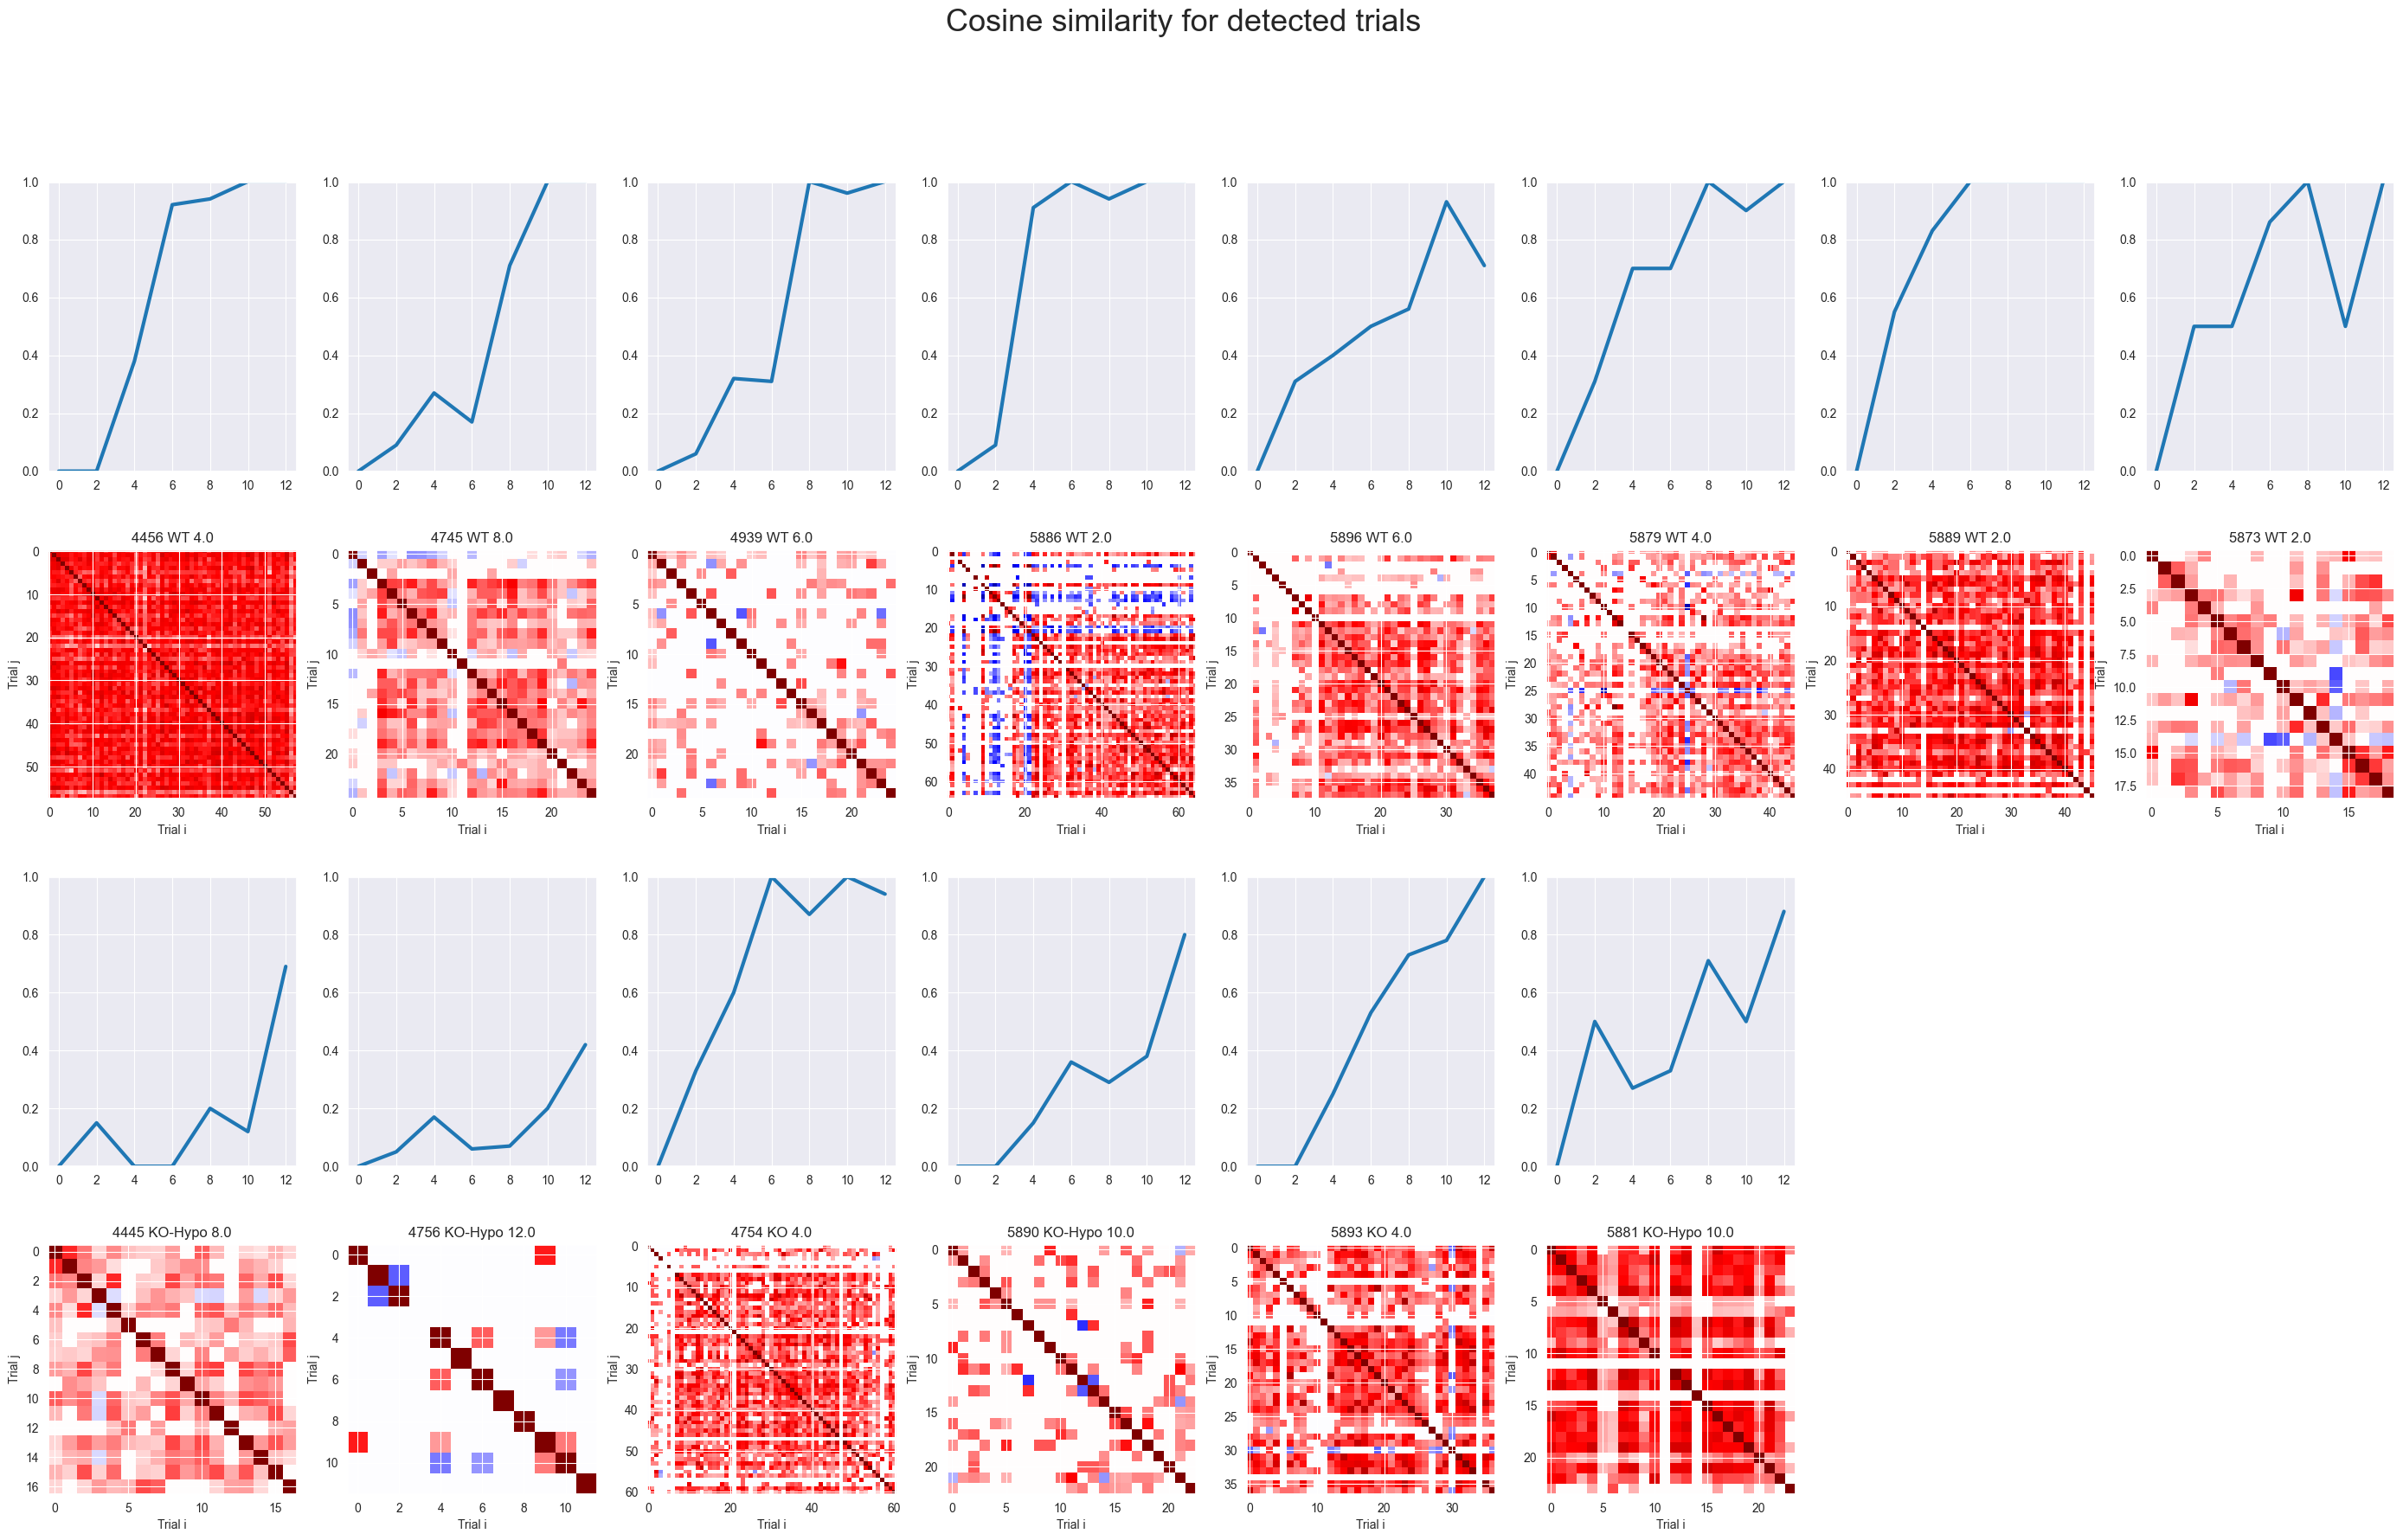

In [8]:
y, i = 0, 0
amps = [2, 6, 6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(35, 20))

for rec, amp in zip(recs.values(), amps):
        # rec.responsivity()
        resp_m=np.transpose(rec.matrices["EXC"]["Responsivity"])[rec.detected_stim]
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            cosine_matrix(ax[1, i], rec, rec.threshold,resp_m)
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            cosine_matrix(ax[3, y], rec, rec.threshold,resp_m)
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Cosine similarity for detected trials', fontsize=26)

## Cosine similarity matrices for every non detected trials

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


Text(0.5, 0.98, 'Cosine similarity for non detected trials')

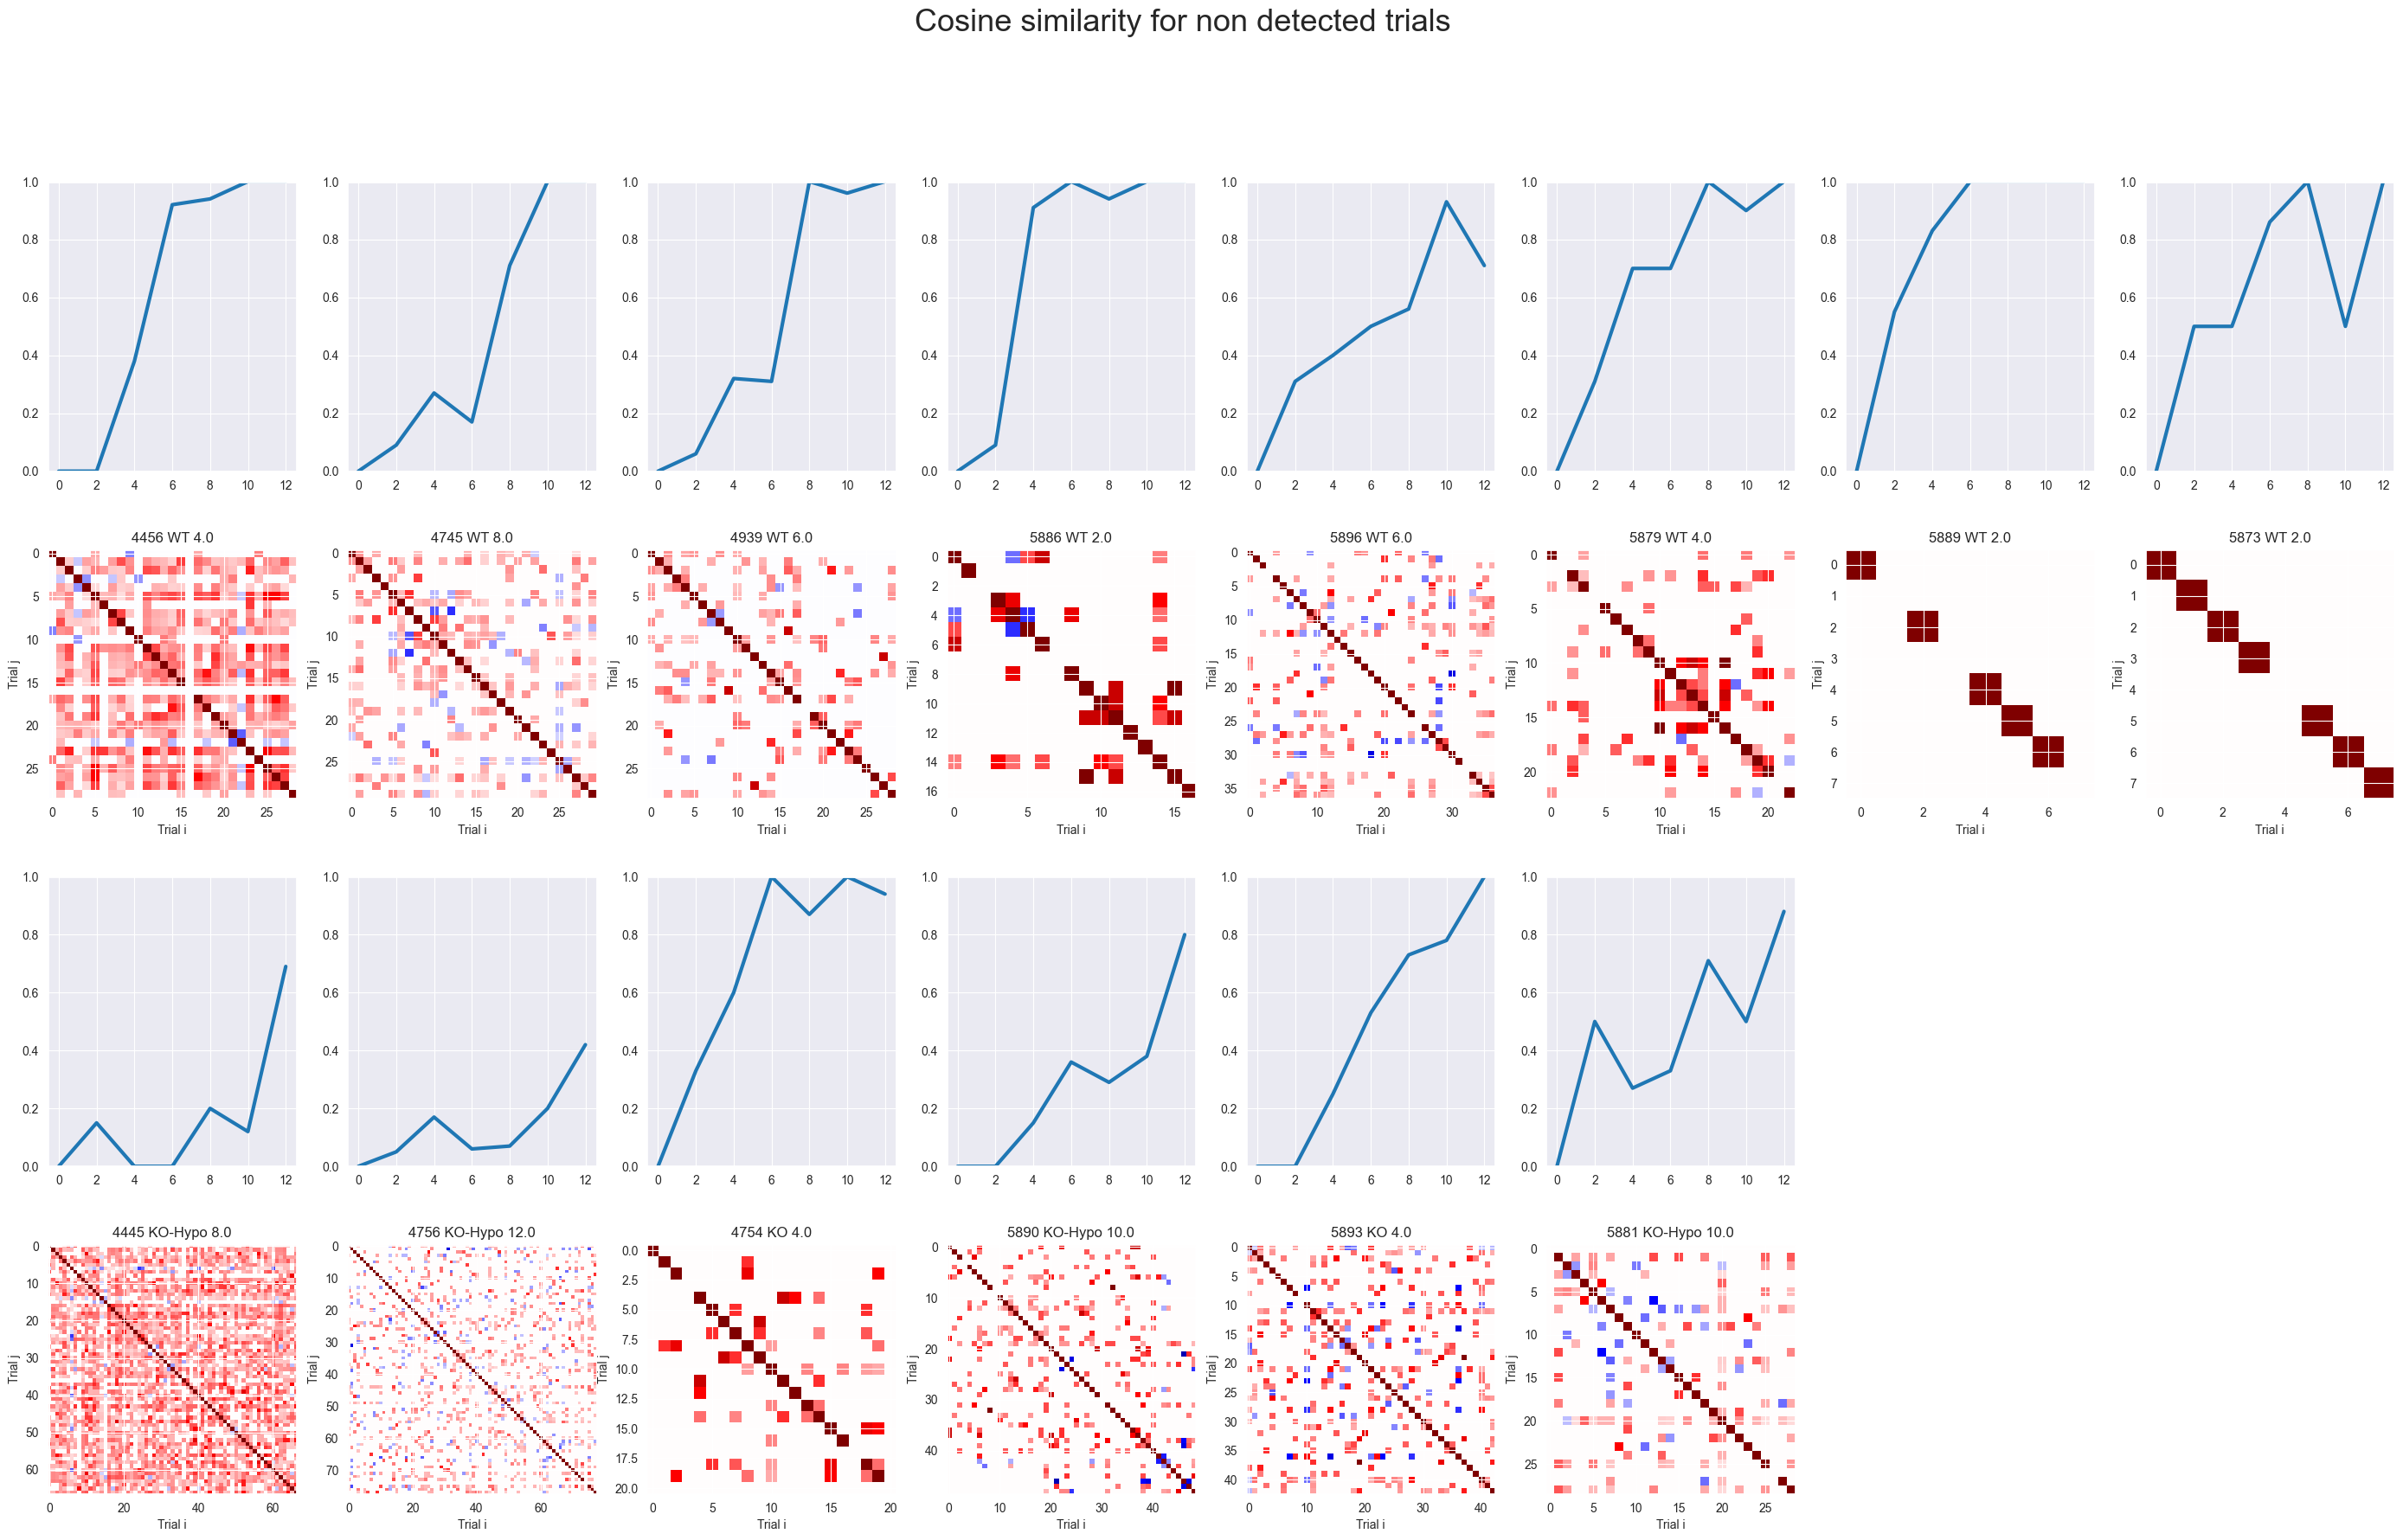

In [9]:
y, i = 0, 0
amps = [2, 6,6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(35, 20))

for rec, amp in zip(recs.values(), amps):
        # rec.responsivity()
        resp_m=np.transpose(rec.matrices["EXC"]["Responsivity"])[~rec.detected_stim]
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            cosine_matrix(ax[1, i], rec, rec.threshold,resp_m)
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            cosine_matrix(ax[3, y], rec,rec.threshold,resp_m)
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Cosine similarity for non detected trials', fontsize=26)

## Cosine similarity matrices for trials with stim amplitude equal to threshold

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


Text(0.5, 0.98, 'Cosine similarity for trials with stim amp equal to threshold')

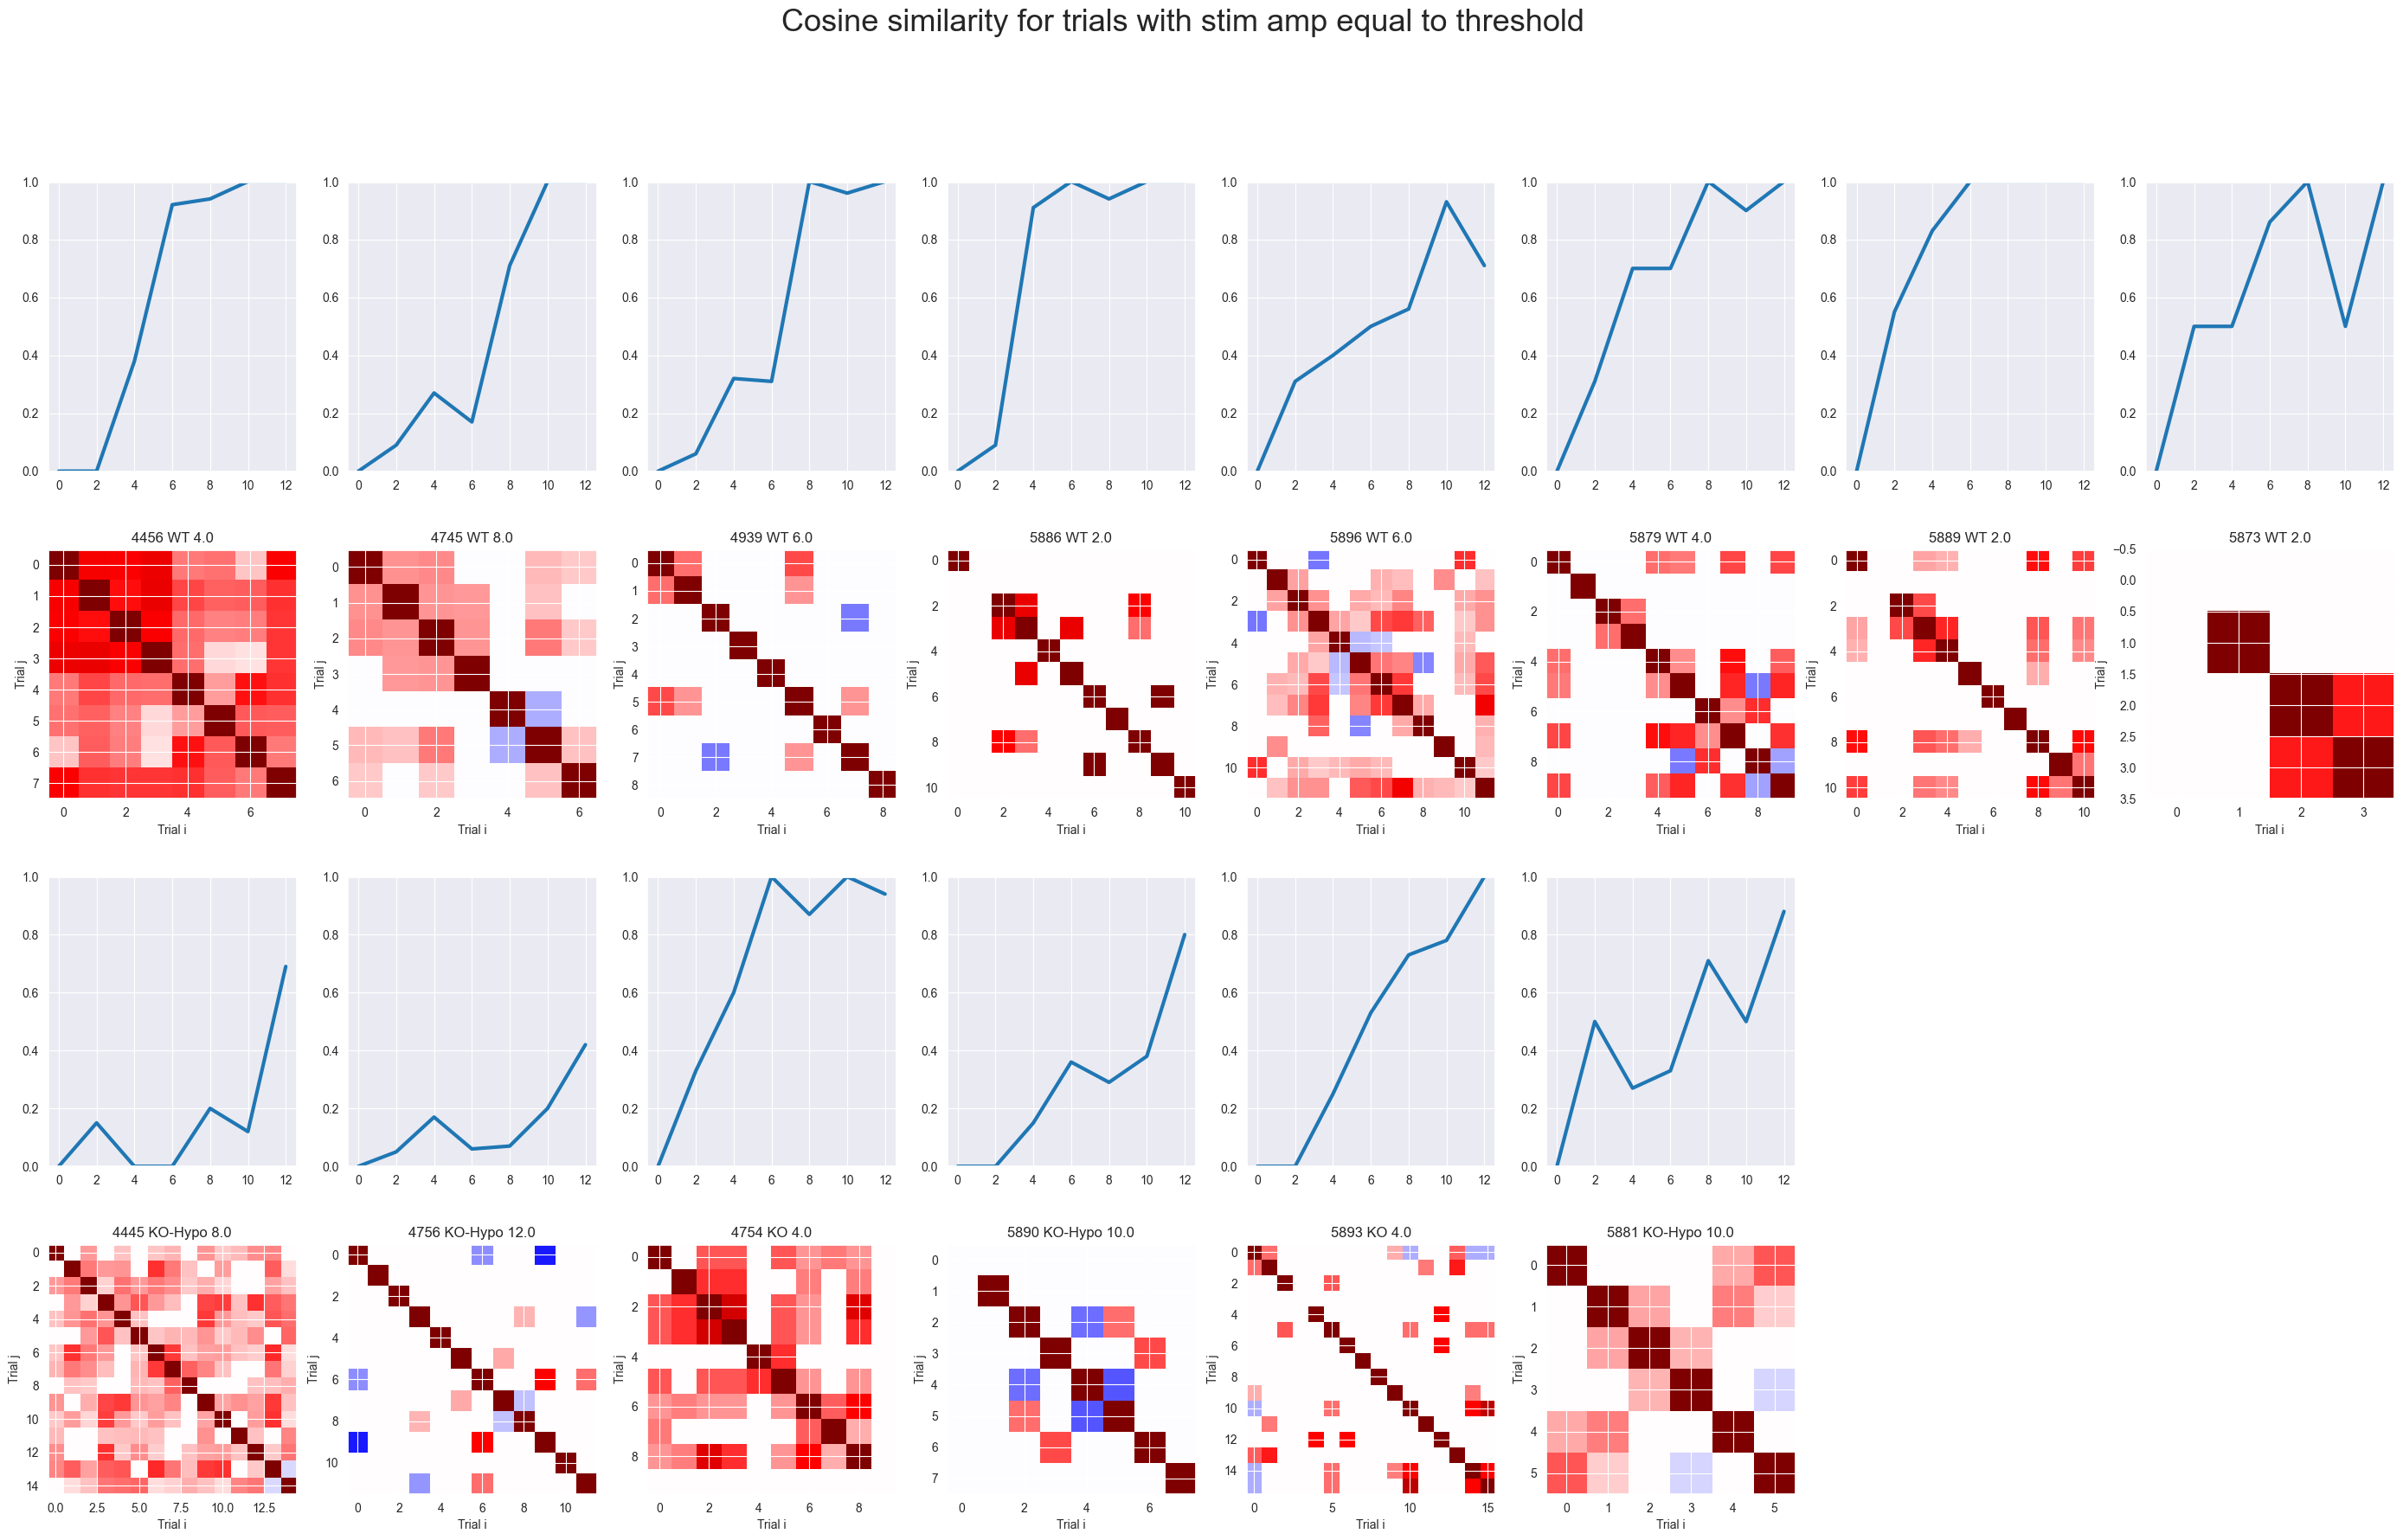

In [11]:
y, i = 0, 0
amps = [2, 6,6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(35, 20))

for rec, amp in zip(recs.values(), amps):
        # rec.responsivity()
        resp_m=np.transpose(rec.matrices["EXC"]["Responsivity"])[rec.stim_ampl==rec.threshold]
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            cosine_matrix(ax[1, i], rec, rec.threshold,resp_m)
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            cosine_matrix(ax[3, y], rec, rec.threshold,resp_m)
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Cosine similarity for trials with stim amp equal to threshold', fontsize=26)

# Cosine similarity based on zscore

---

In [12]:
def neuron_mean_std_corr(array, estimator):
    if estimator == "Mean":
        return np.mean(array, axis=0)
    if estimator == "Std":
        return np.std(array, axis=0)
    

def get_zscore(rec, exc_neurons=True, inh_neurons=False):
        if exc_neurons and inh_neurons:
            zscore = np.row_stack((rec.zscore_exc, rec.zscore_inh)).T
        elif exc_neurons:
            zscore = rec.zscore_exc.T
        elif inh_neurons:
            zscore = rec.zscore_inh.T
        return zscore

def get_zscore_estimator(rec, estimator, exc_neurons=True, inh_neurons=True):
    zscore = get_zscore(rec, exc_neurons=exc_neurons, inh_neurons=inh_neurons)
    first = True
    for i in range(rec.stim_time.shape[0]):
        start = rec.stim_time[i]
        end = rec.stim_time[i] + int(rec.stim_durations[i])
        if first:
            X = neuron_mean_std_corr(zscore[start : end], estimator)
            first = False
        else:
            new_row = neuron_mean_std_corr(zscore[start : end], estimator)
            X = np.row_stack((X, new_row))
    return X

## Cosine similarity for every trials (Mean zscore)

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


Text(0.5, 0.98, 'Cosine similarity for all trials')

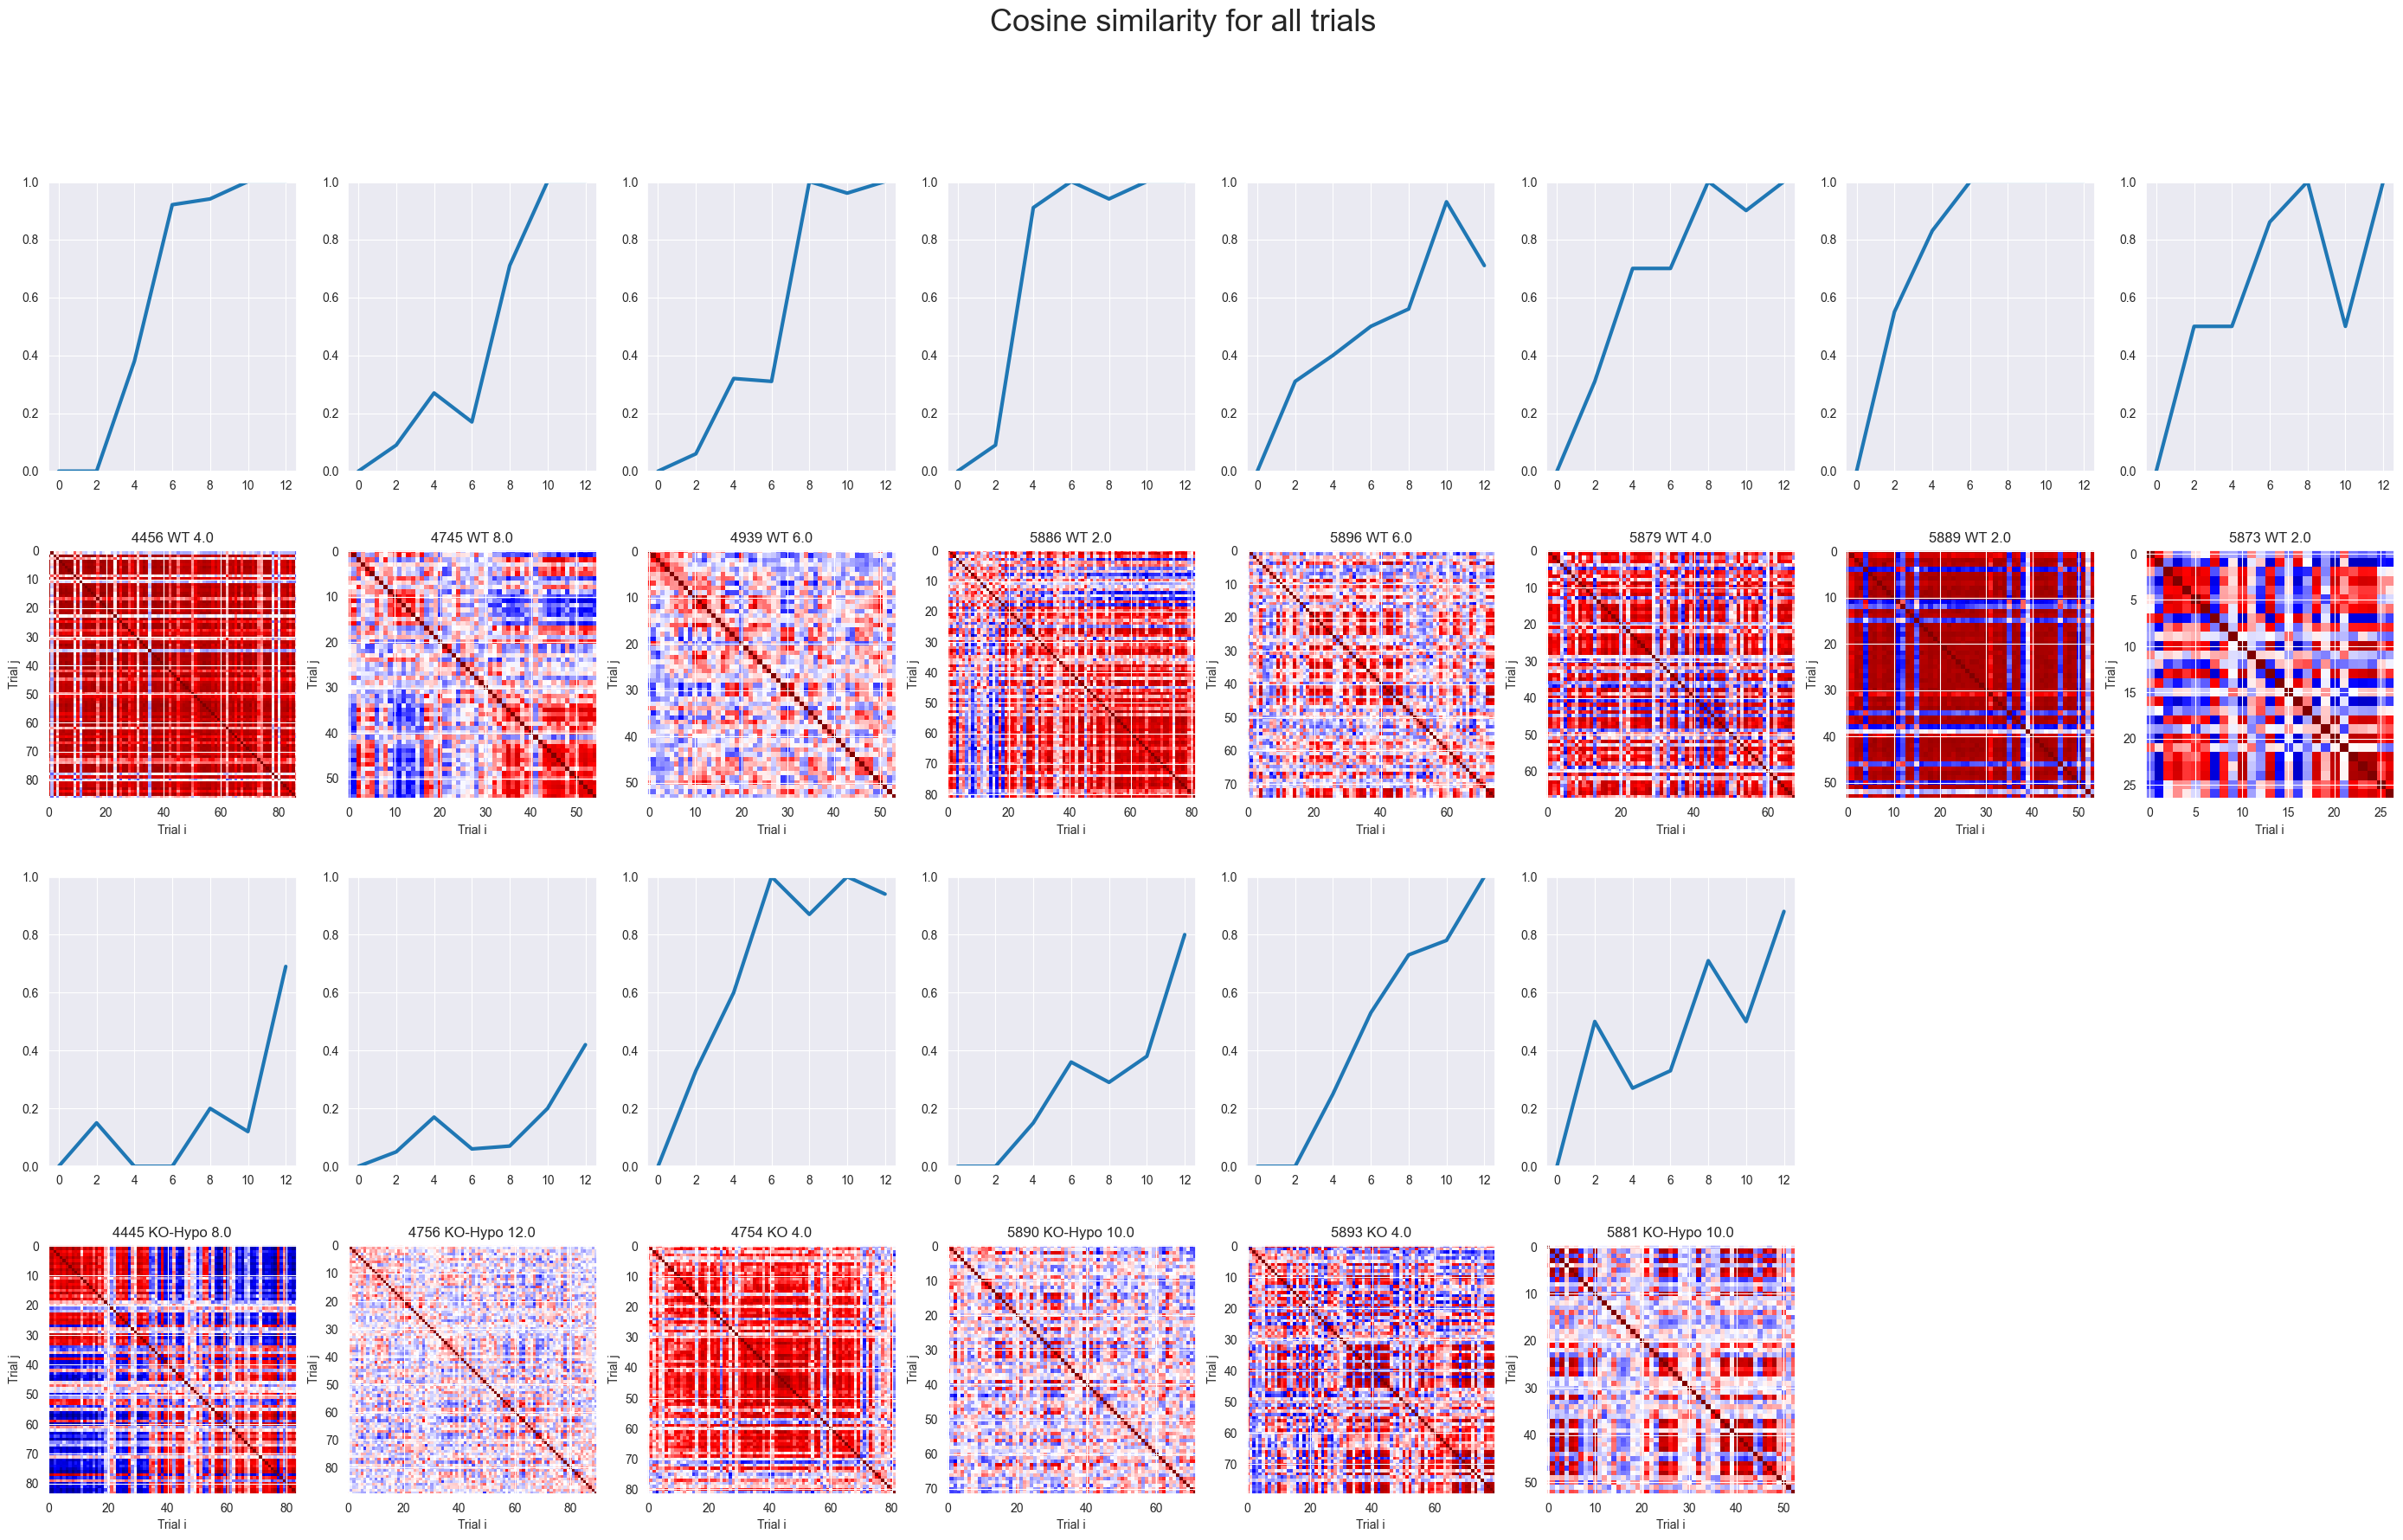

In [14]:
y, i = 0, 0
fig, ax = plt.subplots(4, 8, figsize=(35, 20))
estimator = "Mean"

for rec, amp in zip(recs.values()):

        resp_m=get_zscore_estimator(rec, estimator)
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            cosine_matrix(ax[1, i], rec, rec.threshold,resp_m)
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            cosine_matrix(ax[3, y], rec, rec.threshold,resp_m)
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Cosine similarity for all trials', fontsize=26)

## Cosine similarity for every trials (Std of zscore)

Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation
Cosine similarity computation


Text(0.5, 0.98, 'Cosine similarity for all trials')

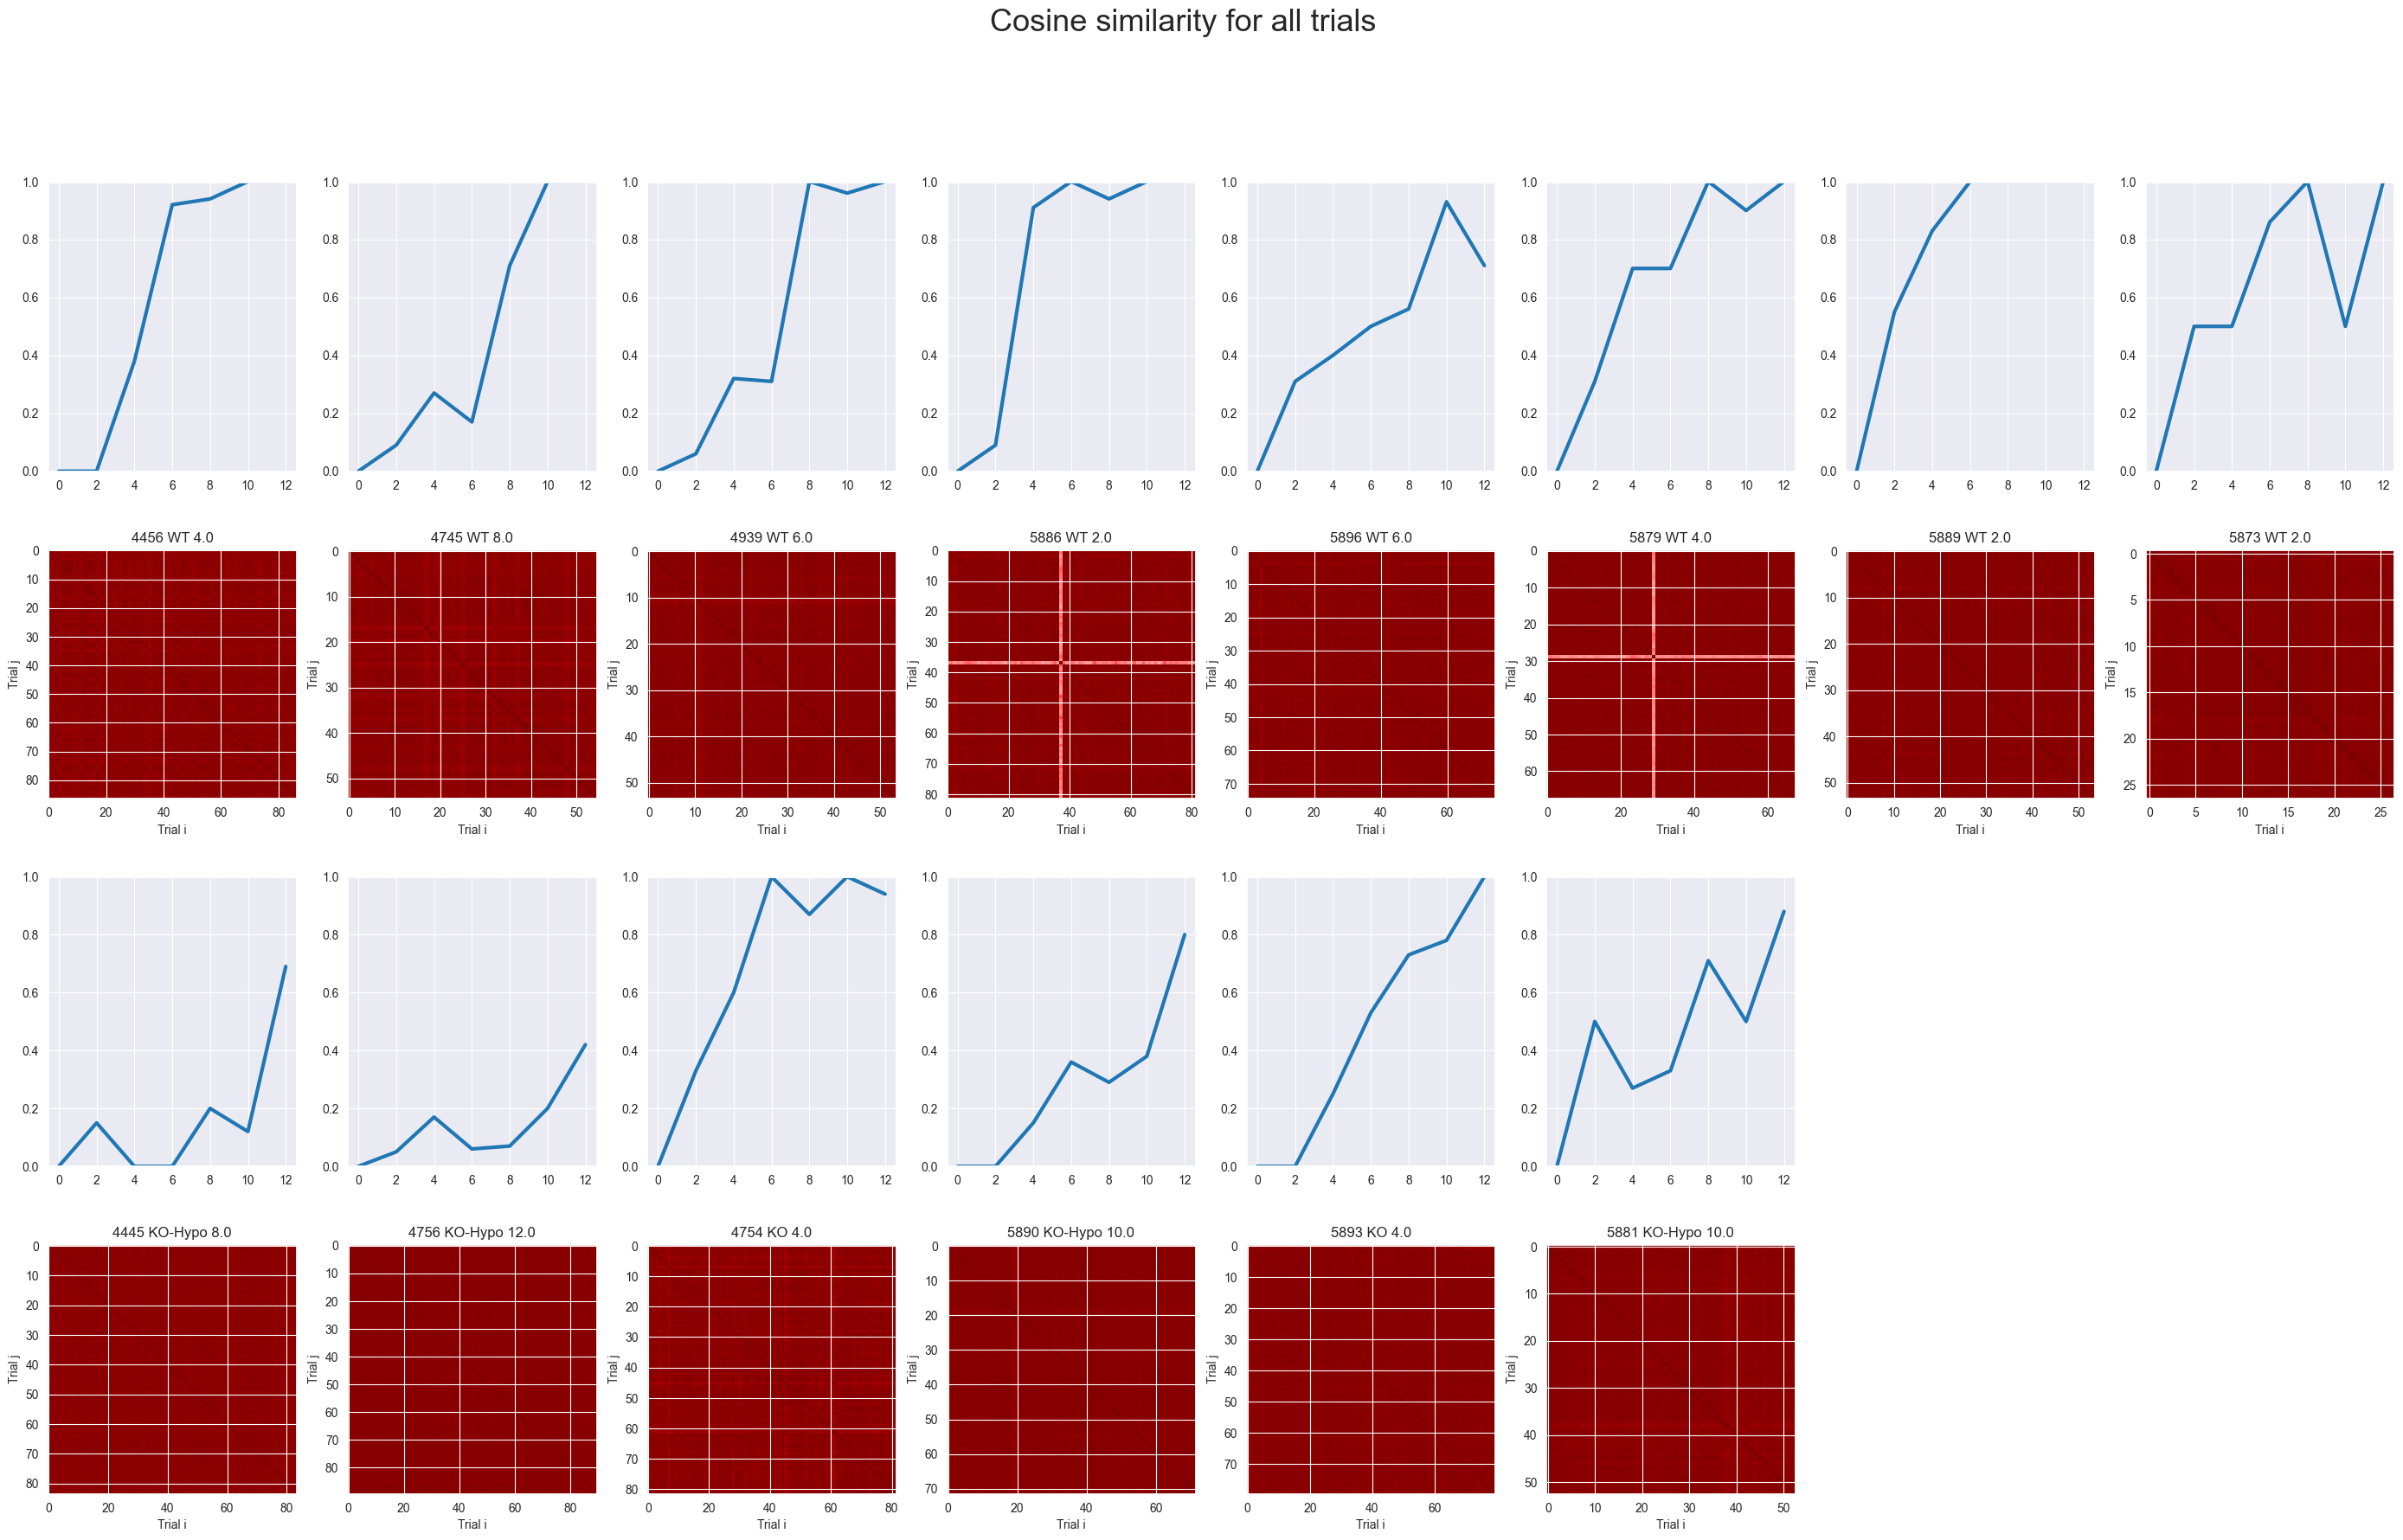

In [15]:
y, i = 0, 0
amps = [2, 6,6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 8, figsize=(35, 20))
estimator = "Std"

for rec, amp in zip(recs.values(), amps):

        resp_m=get_zscore_estimator(rec, estimator)
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            cosine_matrix(ax[1, i], rec, rec.threshold,resp_m)
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            cosine_matrix(ax[3, y], rec, rec.threshold,resp_m)
            y = y + 1

ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Cosine similarity for all trials', fontsize=26)